# Statistics for Business

Project Sekolah Data Pacmann Ai

#### Import Liblary

In [45]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.gridspec import GridSpec
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import colorlover as cl 
#stats
import scipy.stats as stats


from pathlib import Path
from datetime import date

import warnings
warnings.filterwarnings("ignore") 

#### **Loading data into Dataframe**

In [34]:
marketing = pd.read_csv('marketing.csv')
marketing.head()

,Ad Group,Month,Impressions,Clicks,CTR,Conversions,Conv Rate,Cost,CPC,Revenue,Sale Amount,P&L
0,Shop - 1:1 - Desk - [shop coupon code],July,16038,6504,0.41,1166,0.10,6669,1.03,6402,136770.05,-267.086
1,Shop - 1:1 - Desk - [shop coupon],July,36462,14367,0.39,2188,0.09,13746,0.96,13262,283215.21,-483.951
2,Shop - 1:1 - Desk - [shop discount code],July,3635,1458,0.40,248,0.09,1606,1.10,1723,39165.46,117.136
3,Shop - 1:1 - Desk - [shop promo code],July,26185,10418,0.40,2294,0.12,13278,1.27,13042,284823.48,-235.921
4,Shop - 1:1 - Desk - [shop promo],July,808,282,0.35,61,0.15,391,1.39,337,7717.77,-53.604


- First, we should take a look at our dataset. 
 - We can check the number of observation that experience old web page and the new one 
 - Check Missing Value, and handle it if any.
 - Check duplicates, and handle it if any.

In [35]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Ad Group     190 non-null    object 
 1   Month        190 non-null    object 
 2   Impressions  190 non-null    int64  
 3   Clicks       190 non-null    int64  
 4   CTR          190 non-null    float64
 5   Conversions  190 non-null    int64  
 6   Conv Rate    190 non-null    float64
 7   Cost         190 non-null    int64  
 8   CPC          190 non-null    float64
 9   Revenue      190 non-null    int64  
 10  Sale Amount  190 non-null    float64
 11  P&L          190 non-null    float64
dtypes: float64(5), int64(5), object(2)
memory usage: 17.9+ KB


In [36]:
marketing.isnull().sum()

Ad Group       0
Month          0
Impressions    0
Clicks         0
CTR            0
Conversions    0
Conv Rate      0
Cost           0
CPC            0
Revenue        0
Sale Amount    0
P&L            0
dtype: int64

In [37]:
marketing['Ad Group'].value_counts().head()

Shop - 1:1 - Desk - [shop coupon code]    5
Shop - Phrase - Desk - Promo Code         5
Shop - Exact - Mob - Offer                5
Shop - Exact - Mob - Promo Code           5
Shop - Exact - Mob - Sale                 5
Name: Ad Group, dtype: int64

#### **Manipulation Data**

In [38]:
# split the "ad_group" column by " - " and create new columns
marketing[["name_store", "keyword_match", "device_type", "landing_page"]] = marketing["Ad Group"].str.split(" - ", expand=True)

In [39]:
marketing

,Ad Group,Month,Impressions,Clicks,CTR,Conversions,Conv Rate,Cost,CPC,Revenue,Sale Amount,P&L,name_store,keyword_match,device_type,landing_page
0,Shop - 1:1 - Desk - [shop coupon code],July,16038,6504,0.41,1166,0.10,6669,1.03,6402,136770.05,-267.086,Shop,1:1,Desk,[shop coupon code]
1,Shop - 1:1 - Desk - [shop coupon],July,36462,14367,0.39,2188,0.09,13746,0.96,13262,283215.21,-483.951,Shop,1:1,Desk,[shop coupon]
2,Shop - 1:1 - Desk - [shop discount code],July,3635,1458,0.40,248,0.09,1606,1.10,1723,39165.46,117.136,Shop,1:1,Desk,[shop discount code]
3,Shop - 1:1 - Desk - [shop promo code],July,26185,10418,0.40,2294,0.12,13278,1.27,13042,284823.48,-235.921,Shop,1:1,Desk,[shop promo code]
4,Shop - 1:1 - Desk - [shop promo],July,808,282,0.35,61,0.15,391,1.39,337,7717.77,-53.604,Shop,1:1,Desk,[shop promo]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,Shop - Exact - Desk - Black Friday/Cyber Monday,November,257,24,0.09,7,0.28,3,0.14,45,898.80,41.946,Shop,Exact,Desk,Black Friday/Cyber Monday
186,Shop - 1:1 - Desk - [shop discount code],November,7254,2725,0.38,512,0.11,3182,1.17,3227,66672.29,45.468,Shop,1:1,Desk,[shop discount code]
187,Shop - Exact - Desk - Coupon Code,November,18526,5553,0.30,919,0.10,5982,1.08,6047,129556.90,64.552,Shop,Exact,Desk,Coupon Code
188,Shop - Exact - Mob - Black Friday/Cyber Monday,November,3662,266,0.07,24,0.09,44,0.17,160,3268.63,115.963,Shop,Exact,Mob,Black Friday/Cyber Monday


In [52]:
unique_values_landing_page = marketing['landing_page'].unique()
unique_values_landing_page

array(['[shop coupon code]', '[shop coupon]', '[shop discount code]',
       '[shop promo code]', '[shop promo]', 'Competitor', 'Coupon Code',
       'Discount Code', 'Free Shipping', 'Offer', 'Promo Code', 'Sale',
       'Black Friday/Cyber Monday'], dtype=object)

## **Statistics Test**
___

The company has been tracking the Click for the Landing Page of their shop promo code and shop coupon code for 5 months. The company now wants to conduct a statistical test to determine if there is a significant difference in the Click between the two landing pages.

- What to prove: **Cliks** or the proportion of page from landing page on the **shop promo code** page **greater** than the **shop coupon code** page
- Let $p_1$ is the proportion of convertion from landing on the **shop promo code** page and $p_2$ is the proportion of convertion from landing on the **shop coupon code** page 

- Then we state Null hypothesis ($H_0$) as status quo, where we shouldn't do anything and have no data 
 - $H_0$: the probability of all users who cliks from landing on the shop promo code page is **less than or equal** to the probability of all users who clicks from landing on the shop coupon code. 
   $$H_0:P_1 \leq P_2$$
- Alternative hypothesis ($H_1$) is the opposite claim from null hypothesis
 - $H_1$: the probability of all users who cliks from landing on the shop coupon code page is **greater than** the probability of all users who clicks from landing on the shop promo code page. $$H_1:P_1 > P_2$$
- Set siginificance level (alpha)
 - Significance level = 0.05`

#### **Define Null & Alternate Hypothesis**

*What the default condition in the company?*
- [x] There is significant difference in the Click between the landing page for `shop promo code` and `shop coupon code`.
- [ ] There is no a significant difference in the Click between the two landing pages for `shop promo code` and `shop coupon code`

<font color="blue">Explaination</font><br>
This means that the company assumes that both landing pages have the same Clicks and that any observed differences are due to chance.

#### 1. Define Hyphoteses  

$H_0: \mu_{\text{shop promo code}} \geq \mu_{\text{shop coupon code}}$

$H_1: \mu_{\text{shop promo code}} < \mu_{\text{shop coupon code}}$

#### 2. Compute z-statistics

$$ z = \frac{\hat{p}-p_{o}}{\sqrt{\frac{p_{o}(1-p_{o})}{n}}} $$

- Use the proportion_ztest() function to calculate z-statistics and p-value for one-sample proportions test

```python
zstats, pval = proportions_ztest(count = ...,
                                 nobs = ...,
                                 value = ...,
                                 alternative = ...)
```
in which
- `count` : number of successes
- `nobs` : number of observations
- `value` : the value of the null hypothesis equal to the proportion in the case of a one sample test. 
- `alternative` : It depends on the alternative hypothesis for the test
    - if $H_1$ is not equal to certain value, we use `two-sided`
    - if $H_1$ is larger than certain value, we use `larger`
    - if $H_1$ is smaller than certain value, we use `smaller` 

In [97]:
from statsmodels.stats.proportion import proportions_ztest

In [101]:
# Perform two proportion z-test
test_stat, p_value = proportions_ztest(count = [promo, converted_old], 
                                                nobs = [n_new, n_old], 
                                                alternative = 'larger')

print("The computed Z test statistic is: ",np.round(test_stat, 4))
print("The p-value is: ", np.round(p_value,4))

NameError: name 'converted_new' is not defined

In [102]:
promo

3      10418
8      27121
38     17655
39      7673
77     14427
78      6199
115    15595
116     6484
153    23538
159    57405
Name: Clicks, dtype: int64

In [94]:
# import proportion_ztest function
from statsmodels.stats.proportion import proportions_ztest

# perform one-sample proportion z-test
z_stat, p_value = proportions_ztest(count = 12, nobs = 100, value=0.2, alternative='smaller')
    
print(f"z stats : {z_stat:.4f}")
print(f"p-value : {p_value:.4f}")

z stats : -2.4618
p-value : 0.0069


In [89]:
promo = marketing[marketing['landing_page'] == '[shop promo code]']['Clicks']
coupon = marketing[marketing['landing_page'] == '[shop coupon code]']['Clicks']


promo_mean = promo.mean()
coupon_mean = coupon.mean()
promo_std = promo.std(ddof=1) # use ddof=1 for unbiased standard deviation
coupon_std = coupon.std(ddof=1)

# calculate the standard error and the z statistic
n_promo = len(promo)
n_coupon = len(coupon)
se = np.sqrt((promo_std**2/n_promo) + (coupon_std**2/n_coupon))
z_stat = (promo_mean - coupon_mean) / se

# calculate the p-value using a one-tailed test
p_value = 1 - stats.norm.cdf(z_stat)

# print the results
print(f"z stats: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

z stats: 0.8290
p-value: 0.2035


since the p-value (0.2035) is greater than the significance level, we fail to reject the null hypothesis. Therefore, we cannot conclude that there is a significant difference in the Click between the landing page for shop promo code and shop coupon code.

In [90]:
# critical value in our case is z-value where the left-tailed area under a standard normal distribution is 0.05 (alpha)
import scipy.stats as stats
z_crit = stats.norm.ppf(1-0.05)
print(z_crit)

1.6448536269514722


In [91]:
# Decision rule based on p-value

if p_value<0.05:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the Null hypothesis")

Failed to reject the Null hypothesis


In [92]:
# Decision rule based on critical value

if z_stat<z_crit:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the Null hypothesis")

Reject the null hypothesis


This means that there is not enough evidence to conclude that there is a significant difference in the number of clicks between the two landing pages. The decision rule based on the critical value also supports this conclusion, as the calculated z-statistic is less than the critical value of 1.6448.as_integer_ratio

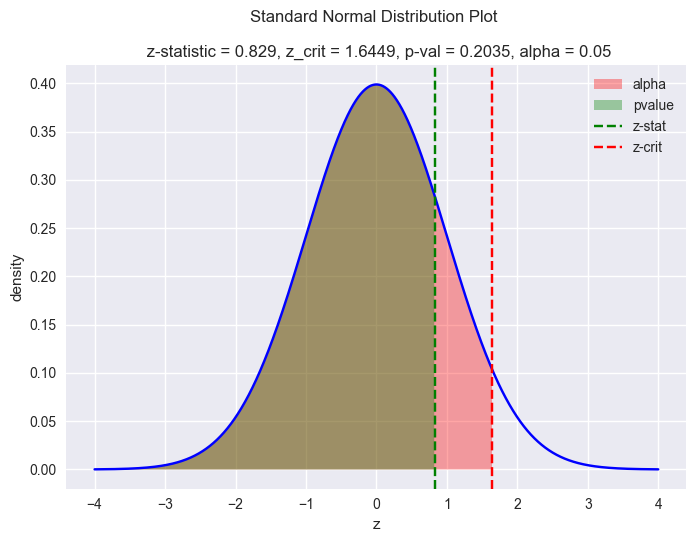

In [86]:
# Visualization
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot sample distribution 
x = np.arange(-4, 4, 0.001)
plt.plot(x, stats.norm.pdf(x, 0, 1), 
         color='blue')

# plot alpha region
x_alpha = np.arange(-4,z_crit, 0.01)
y_alpha = stats.norm.pdf(x_alpha)
plt.fill_between(x = x_alpha, 
                 y1 = y_alpha,
                 facecolor = 'red',
                 alpha = 0.35, 
                 label = 'alpha')

# plot pvalue
x_pvalue = np.arange(-4,z_stat, 0.01)
y_pvalue = stats.norm.pdf(x_pvalue)
plt.fill_between(x = x_pvalue, 
                 y1 = y_pvalue,
                 facecolor = 'green',
                 alpha = 0.35, 
                 label = 'pvalue')

# plot z-crit and z-stats
plt.axvline(np.round(z_stat, 4), 
            color ="green", 
            linestyle = "--", 
            label ="z-stat")
plt.axvline(z_crit, 
            color ="red", 
            linestyle = "--", 
            label ="z-crit")

plt.legend()
plt.xlabel("z")
plt.ylabel("density")

plt.title(f'Standard Normal Distribution Plot \n\n z-statistic = {np.round(z_stat, 4)}, z_crit = {np.round(z_crit, 4)}, p-val = {np.round(p_value, 4)}, alpha = 0.05');